# Import nécessaires 


In [1]:
import pandas as pd
import csv
import os
import gc
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
# Fonction pour fractionner et nettoyer un fichier CSV par morceaux
def process_csv_in_chunks(file_path, chunk_size=10000, expected_columns=122, sample_fraction=0.10):
    # Récupérer le nom de base du fichier (sans extension) pour les fichiers de sortie
    base_name = os.path.splitext(file_path)[0]
    # Initialiser le compteur de morceaux
    chunk_number = 0
    # Liste pour stocker les échantillons nettoyés de chaque morceau
    cleaned_samples = []
    
    # Ouvrir le fichier CSV en mode lecture
    with open(file_path, 'r') as file:
        # Créer un lecteur CSV
        reader = csv.reader(file)
        # Lire l'en-tête (première ligne)
        header = next(reader)
        # Initialiser le premier morceau avec l'en-tête
        chunk = [header]
        
        # Parcourir chaque ligne du fichier CSV
        for i, line in enumerate(reader):
            # Si on atteint la taille du morceau
            if (i + 1) % chunk_size == 0:
                # Ajouter la ligne actuelle au morceau
                chunk.append(line)
                # Nettoyer le morceau
                cleaned_chunk = clean_chunk(chunk, expected_columns)
                # Prendre un échantillon du morceau nettoyé
                sample_chunk = sample_chunk_data(cleaned_chunk, sample_fraction)
                # Ajouter l'échantillon nettoyé à la liste des échantillons nettoyés
                cleaned_samples.append(sample_chunk)
                # Incrémenter le compteur de morceaux
                chunk_number += 1
                # Réinitialiser le morceau avec l'en-tête
                chunk = [header]
            else:
                # Ajouter la ligne actuelle au morceau
                chunk.append(line)
        
        # Traiter les lignes restantes si le morceau n'est pas vide
        if chunk:
            # Nettoyer le morceau restant
            cleaned_chunk = clean_chunk(chunk, expected_columns)
            # Prendre un échantillon du morceau nettoyé
            sample_chunk = sample_chunk_data(cleaned_chunk, sample_fraction)
            # Ajouter l'échantillon nettoyé à la liste des échantillons nettoyés
            cleaned_samples.append(sample_chunk)
    
    # Combiner tous les échantillons nettoyés en un seul DataFrame
    final_sample = pd.concat(cleaned_samples, axis=0)
    # Retourner le DataFrame final
    return final_sample


In [3]:
# Fonction pour nettoyer un morceau de données
def clean_chunk(chunk, expected_columns):
    # Initialiser le morceau nettoyé avec l'en-tête (première ligne)
    cleaned_chunk = [chunk[0]]  
    # Parcourir chaque ligne du morceau (en excluant l'en-tête)
    for row in chunk[1:]:
        # Vérifier si le nombre de colonnes dans la ligne est égal au nombre attendu
        if len(row) == expected_columns:
            # Ajouter la ligne au morceau nettoyé si elle a le bon nombre de colonnes
            cleaned_chunk.append(row)
    # Retourner le morceau nettoyé
    return cleaned_chunk


In [4]:
# Fonction pour échantillonner un morceau de données
def sample_chunk_data(chunk, sample_fraction):
    # Convertir le morceau en DataFrame pandas, en utilisant la première ligne comme en-têtes de colonnes
    df_chunk = pd.DataFrame(chunk[1:], columns=chunk[0])
    
    # Prendre un échantillon du DataFrame en fonction de la fraction spécifiée
    sample_chunk = df_chunk.sample(frac=sample_fraction, random_state=1)
    
    # Retourner le DataFrame échantillonné
    return sample_chunk


In [5]:
# Liste des fichiers et leurs colonnes attendues
files_and_columns = {
    './application_train.csv': 122,
    './application_test.csv': 121,
}

# Processer chaque fichier CSV et sauvegarder les fragments propres
cleaned_samples = {}
for file, col_count in files_and_columns.items():
    # Afficher un message indiquant le début du traitement du fichier
    print(f"Processing {file}...")
    
    # Appeler la fonction pour traiter le fichier CSV en morceaux
    cleaned_samples[file] = process_csv_in_chunks(file, chunk_size=10000, expected_columns=col_count, sample_fraction=0.10)
    
    # Afficher un message indiquant la fin du traitement du fichier
    print(f"Finished processing {file}.")
    
    # Afficher les premières lignes de l'échantillon nettoyé
    print(cleaned_samples[file].head())
    
    # Sauvegarder les fragments propres dans un nouveau fichier CSV
    cleaned_samples[file].to_csv(f'cleaned_{os.path.basename(file)}', index=False)
    
    # Nettoyer la mémoire après chaque fichier
    gc.collect()


Processing ./application_train.csv...
Finished processing ./application_train.csv.
     SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
9953     111583      1         Cash loans           M            Y   
3850     104503      0         Cash loans           M            N   
4962     105806      0         Cash loans           F            N   
3886     104546      0         Cash loans           F            Y   
5437     106364      0         Cash loans           F            N   

     FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
9953               Y            1         270000.0   755190.0     36459.0   
3850               Y            0         112500.0   765000.0     39190.5   
4962               Y            2          67500.0   509602.5     22576.5   
3886               N            0          90000.0   684000.0     19998.0   
5437               Y            1         112500.0   187704.0     14958.0   

      ... FLAG_DOCUMENT_18 FLAG_D

In [6]:
# Fonction pour traiter les valeurs manquantes et encoder les variables catégorielles
def preprocess_data(df):
    # Séparation des colonnes numériques et catégorielles
    numeric_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Imputation des valeurs manquantes pour les colonnes numériques uniquement
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    
    # Encodage des variables catégorielles
    df = pd.get_dummies(df, columns=categorical_cols)
    
    return df


In [7]:
# Fonction pour normaliser les données
def normalize_data(df):
    # Créer une instance de StandardScaler
    scaler = StandardScaler()
    
    # Appliquer la normalisation et convertir le résultat en DataFrame
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    # Retourner le DataFrame normalisé
    return df_scaled


In [8]:
# Charger les fichiers nettoyés
application_train = pd.read_csv('cleaned_application_train.csv')
application_test = pd.read_csv('cleaned_application_test.csv')

In [9]:
application_train = preprocess_data(application_train)
application_test = preprocess_data(application_test)

In [10]:
# Normaliser chaque fichier
application_train = normalize_data(application_train)
# application_test = normalize_data(application_test)

In [11]:
# Charger les fichiers nettoyés
application_train = pd.read_csv('cleaned_application_train.csv')

# Imputation des valeurs manquantes pour les colonnes numériques
numeric_cols = application_train.select_dtypes(include=['number']).columns
application_train[numeric_cols] = application_train[numeric_cols].fillna(application_train[numeric_cols].mean())

# Vérifier les types de colonnes avant la suppression des colonnes non numériques
print("Types de colonnes avant la suppression des colonnes non numériques :")
print(application_train.dtypes)

# Suppression des colonnes non numériques
application_train = application_train.select_dtypes(include=[float, int])

# Vérifier les types de colonnes après suppression des colonnes non numériques
print("Types de colonnes après la suppression des colonnes non numériques :")
print(application_train.dtypes)

# Séparer les caractéristiques (features) et la cible (target)
X = application_train.drop('TARGET', axis=1)
y = application_train['TARGET']

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Appliquer SMOTE à l'ensemble d'entraînement pour gérer le déséquilibre des classes
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


Types de colonnes avant la suppression des colonnes non numériques :
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object
Types de colonnes après la suppression des colonnes non numériques :
SK_ID_CURR                      int64
TARGET                          int64
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64

In [12]:
# Save the DataFrame to a CSV file
file_path = './data.csv'
application_train.to_csv(file_path, index=False)

In [50]:
# Définir les paramètres pour la recherche par grille pour la régression logistique
param_grid_lr = {
    'solver': ['liblinear'],  # Algorithme à utiliser dans le problème d'optimisation. 'liblinear' est un solveur adapté aux petits ensembles de données.
    'C': [0.1],  # Inverse de la force de régularisation; plus la valeur de C est petite, plus la régularisation est forte.
    'max_iter': [1000]  # Nombre maximal d'itérations pour les algorithmes de convergence.
}

# Définir les paramètres pour la recherche par grille pour la forêt aléatoire
param_grid_rf = {
    'n_estimators': [10, 20, 30],  # Réduire le nombre d'estimateurs pour un temps d'exécution plus court
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Définir les paramètres pour la recherche par grille pour le boosting par gradient
param_grid_gb = {
    'n_estimators': [1, 10],  # Nombre d'arbres de décision à construire. Un nombre plus élevé améliore généralement la performance mais augmente le temps de calcul.
    'learning_rate': [0.1],  # Taux d'apprentissage qui pèse la contribution de chaque arbre. Une valeur plus basse signifie une formation plus lente mais potentiellement une meilleure précision.
    'max_depth': [5]  # Profondeur maximale des arbres individuels. Un arbre plus profond peut modéliser des relations plus complexes mais risque de surajustement.
}


In [41]:
# Configuration de l'expérience MLFlow
mlflow.set_experiment("Model Tracking and Registry")

# Fonction pour enregistrer les métriques avec MLFlow
def log_metrics_with_business_cost(model_name, best_model, X_train, y_train, X_test, y_test, y_pred_proba_train, y_pred_proba_test, fn_cost=10, fp_cost=1):
    # Calcul des métriques pour l'ensemble d'entraînement
    auc_train = roc_auc_score(y_train, y_pred_proba_train)
    accuracy_train = accuracy_score(y_train, (y_pred_proba_train >= 0.5).astype(int))
    precision_train = precision_score(y_train, (y_pred_proba_train >= 0.5).astype(int))
    recall_train = recall_score(y_train, (y_pred_proba_train >= 0.5).astype(int))
    conf_matrix_train = confusion_matrix(y_train, (y_pred_proba_train >= 0.5).astype(int))
    
    best_threshold_train, best_cost_train = find_best_threshold(y_train, y_pred_proba_train, fn_cost, fp_cost)
    business_cost_train = calculate_business_cost(y_train, (y_pred_proba_train >= best_threshold_train).astype(int), fn_cost, fp_cost)
    
    # Calcul des métriques pour l'ensemble de test
    auc_test = roc_auc_score(y_test, y_pred_proba_test)
    accuracy_test = accuracy_score(y_test, (y_pred_proba_test >= 0.5).astype(int))
    precision_test = precision_score(y_test, (y_pred_proba_test >= 0.5).astype(int))
    recall_test = recall_score(y_test, (y_pred_proba_test >= 0.5).astype(int))
    conf_matrix_test = confusion_matrix(y_test, (y_pred_proba_test >= 0.5).astype(int))
    
    best_threshold_test, best_cost_test = find_best_threshold(y_test, y_pred_proba_test, fn_cost, fp_cost)
    business_cost_test = calculate_business_cost(y_test, (y_pred_proba_test >= best_threshold_test).astype(int), fn_cost, fp_cost)
    
    # Enregistrement des paramètres et des métriques avec MLFlow
    mlflow.log_param("Model", model_name)
    mlflow.log_param("Best_Params", best_model.get_params())
    mlflow.log_param("Best_Threshold_Train", best_threshold_train)
    mlflow.log_param("Best_Threshold_Test", best_threshold_test)
    mlflow.log_metric("AUC_Train", auc_train)
    mlflow.log_metric("Accuracy_Train", accuracy_train)
    mlflow.log_metric("Precision_Train", precision_train)
    mlflow.log_metric("Recall_Train", recall_train)
    mlflow.log_metric("Business_Cost_Train", business_cost_train)
    mlflow.log_metric("AUC_Test", auc_test)
    mlflow.log_metric("Accuracy_Test", accuracy_test)
    mlflow.log_metric("Precision_Test", precision_test)
    mlflow.log_metric("Recall_Test", recall_test)
    mlflow.log_metric("Business_Cost_Test", business_cost_test)
    mlflow.sklearn.log_model(best_model, model_name)
    
    # Stocker les résultats dans des DataFrames pour affichage côte à côte
    train_results = {
        "Metric": ["AUC", "Accuracy", "Precision", "Recall", "Best Threshold", "Business Cost"],
        "Train": [auc_train, accuracy_train, precision_train, recall_train, best_threshold_train, business_cost_train]
    }
    
    test_results = {
        "Metric": ["AUC", "Accuracy", "Precision", "Recall", "Best Threshold", "Business Cost"],
        "Test": [auc_test, accuracy_test, precision_test, recall_test, best_threshold_test, business_cost_test]
    }
    
    train_df = pd.DataFrame(train_results)
    test_df = pd.DataFrame(test_results)
    
    # Affichage des résultats côte à côte
    results_df = pd.merge(train_df, test_df, on="Metric")
    print(results_df)
    
    # Affichage des matrices de confusion
    print(f"\nConfusion Matrix (Train):\n{conf_matrix_train}")
    print(f"\nConfusion Matrix (Test):\n{conf_matrix_test}")


def calculate_business_cost(y_true, y_pred, fn_cost=5, fp_cost=1, **kwargs):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fn * fn_cost + fp * fp_cost  # Coût commercial : coût des faux négatifs et des faux positifs
    return cost


def business_cost_scorer(y_true, y_pred_proba, fn_cost=5, fp_cost=1):
    # Convertir les probabilités en prédictions binaires avec un seuil de 0.5
    y_pred = (y_pred_proba >= 0.5).astype(int)
    return calculate_business_cost(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost)

# Créer le scoreur en inversant le coût (car make_scorer cherche à maximiser le score)
cost_scorer = make_scorer(business_cost_scorer, greater_is_better=False, needs_proba=True, fn_cost=10, fp_cost=1)


def find_best_threshold(y_true, y_pred_proba, fn_cost=5, fp_cost=1):
    thresholds = np.arange(0.0, 1.0, 0.01)
    costs = []
    
    for threshold in thresholds:
        cost = calculate_business_cost(y_true, (y_pred_proba >= threshold).astype(int), fn_cost, fp_cost)
        costs.append((cost, threshold))
    
    best_cost, best_threshold = min(costs, key=lambda x: x[0])
    return best_threshold, best_cost

# Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Entraîner et enregistrer les modèles avec GridSearchCV
with mlflow.start_run(run_name="Logistic Regression") as run:
    lr = LogisticRegression(random_state=1)
    grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring=cost_scorer)
    grid_lr.fit(X_train_smote, y_train_smote)
    best_lr = grid_lr.best_estimator_
    
    y_pred_proba_train_lr = best_lr.predict_proba(X_train)[:, 1]
    y_pred_proba_test_lr = best_lr.predict_proba(X_test)[:, 1]
    
    log_metrics_with_business_cost("Logistic Regression", best_lr, X_train, y_train, X_test, y_test, y_pred_proba_train_lr, y_pred_proba_test_lr)
    lr_run_id = run.info.run_id  # Obtenir l'ID de run pour l'enregistrement du modèle

           Metric         Train         Test
0             AUC      0.610984     0.601296
1        Accuracy      0.597957     0.596163
2       Precision      0.107954     0.105295
3          Recall      0.550973     0.545741
4  Best Threshold      0.540000     0.510000
5   Business Cost  34323.000000  8706.000000

Confusion Matrix (Train):
[[26554 17551]
 [ 1731  2124]]

Confusion Matrix (Test):
[[6629 4410]
 [ 432  519]]


Treshold dans api
test unitaire qui passe 


# Random Forest

In [ ]:
#Entraîner et enregistrer les modèles avec GridSearchCV pour Random Forest
with mlflow.start_run(run_name="Random Forest") as run:
    rf = RandomForestClassifier(random_state=1)
    grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring=cost_scorer)
    grid_rf.fit(X_train_smote, y_train_smote)
    best_rf = grid_rf.best_estimator_
    
    y_pred_proba_train_rf = best_rf.predict_proba(X_train)[:, 1]
    y_pred_proba_test_rf = best_rf.predict_proba(X_test)[:, 1]
    
    log_metrics_with_business_cost("Random Forest", best_rf, X_train, y_train, X_test, y_test, y_pred_proba_train_rf, y_pred_proba_test_rf)
    rf_run_id = run.info.run_id  # Obtenir l'ID de run pour l'enregistrement du modèle

# Gradient Boost

In [44]:
# Entraîner et enregistrer les modèles avec GridSearchCV pour Gradient Boosting
with mlflow.start_run(run_name="Gradient Boosting") as run:
    gb = GradientBoostingClassifier(random_state=1)
    grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring=cost_scorer)
    grid_gb.fit(X_train_smote, y_train_smote)
    best_gb = grid_gb.best_estimator_
    
    y_pred_proba_train_gb = best_gb.predict_proba(X_train)[:, 1]
    y_pred_proba_test_gb = best_gb.predict_proba(X_test)[:, 1]
    
    log_metrics_with_business_cost("Gradient Boosting", best_gb, X_train, y_train, X_test, y_test, y_pred_proba_train_gb, y_pred_proba_test_gb)
    gb_run_id = run.info.run_id  # Obtenir l'ID de run pour l'enregistrement du modèle

           Metric         Train         Test
0             AUC      0.679377     0.674317
1        Accuracy      0.847602     0.854045
2       Precision      0.168395     0.181673
3          Recall      0.227497     0.239748
4  Best Threshold      0.380000     0.390000
5   Business Cost  30370.000000  7579.000000

Confusion Matrix (Train):
[[39774  4331]
 [ 2978   877]]

Confusion Matrix (Test):
[[10012  1027]
 [  723   228]]


In [18]:
# Enregistrement des modèles dans le registry
mlflow.register_model(f"runs:/{lr_run_id}/model", "LogisticRegressionModel")
mlflow.register_model(f"runs:/{rf_run_id}/model", "RandomForestModel")
mlflow.register_model(f"runs:/{gb_run_id}/model", "GradientBoostingModel")

Registered model 'LogisticRegressionModel' already exists. Creating a new version of this model...
Created version '21' of model 'LogisticRegressionModel'.
Registered model 'RandomForestModel' already exists. Creating a new version of this model...
Created version '21' of model 'RandomForestModel'.
Registered model 'GradientBoostingModel' already exists. Creating a new version of this model...
Created version '21' of model 'GradientBoostingModel'.


<ModelVersion: aliases=[], creation_timestamp=1722499762047, current_stage='None', description=None, last_updated_timestamp=1722499762047, name='GradientBoostingModel', run_id='ab95bda5506b4f49ab5ec2227e277697', run_link=None, source='file:///C:/Users/Foudil/Projet7/mlruns/331580383598230896/ab95bda5506b4f49ab5ec2227e277697/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=21>

In [19]:
import subprocess

# Lancer le serveur MLflow en arrière-plan
subprocess.Popen(["mlflow", "ui", "--port", "5000"])


<Popen: returncode: None args: ['mlflow', 'ui', '--port', '5000']>

In [20]:
import IPython.display as display

# Afficher le lien pour accéder à l'interface utilisateur de MLflow
display.display(display.Javascript('window.open("//localhost:5000", "_blank");'))


<IPython.core.display.Javascript object>

http://localhost:5000 MLFlow UI

In [21]:
def evaluate_cost_ratios(y_test, y_pred_proba, cost_ratios):
    results = []
    for fn_cost, fp_cost in cost_ratios:
        best_threshold, business_cost = find_best_threshold(y_test, y_pred_proba, fn_cost, fp_cost)
        y_pred = (y_pred_proba >= best_threshold).astype(int)
        
        # Calcul des FN et FP
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        results.append({
            'FN Cost': fn_cost,
            'FP Cost': fp_cost,
            'Best Threshold': best_threshold,
            'Business Cost': business_cost,
            'False Negatives': fn,
            'False Positives': fp
        })
    return results


In [22]:
# Exemples de ratios de coûts à évaluer
cost_ratios = [(5, 1), (10, 1), (20, 1)]

# Prédictions des probabilités sur l'ensemble de test pour le modèle de régression logistique
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# Évaluation des différents ratios de coûts pour la régression logistique
results_lr = evaluate_cost_ratios(y_test, y_pred_proba_lr, cost_ratios)

# Affichage des résultats
print("\n=== Logistic Regression Costs ===")
df_results_lr = pd.DataFrame(results_lr)
print(df_results_lr)



=== Logistic Regression Costs ===
   FN Cost  FP Cost  Best Threshold  Business Cost  False Negatives  \
0        5        1            0.85           4755              951   
1       10        1            0.51           8706              478   
2       20        1            0.35          10658               46   

   False Positives  
0                0  
1             3926  
2             9738  


In [23]:
# Prédictions des probabilités sur l'ensemble de test pour le modèle Random Forest
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Évaluation des différents ratios de coûts pour Random Forest
results_rf = evaluate_cost_ratios(y_test, y_pred_proba_rf, cost_ratios)

# Affichage des résultats
print("\n=== Random Forest Costs ===")
df_results_rf = pd.DataFrame(results_rf)
print(df_results_rf)



=== Random Forest Costs ===
   FN Cost  FP Cost  Best Threshold  Business Cost  False Negatives  \
0        5        1            0.41           4351              800   
1       10        1            0.21           7883              590   
2       20        1            0.01          10868              168   

   False Positives  
0              351  
1             1983  
2             7508  


In [24]:
# Prédictions des probabilités sur l'ensemble de test pour le modèle Gradient Boosting
y_pred_proba_gb = best_gb.predict_proba(X_test)[:, 1]

# Évaluation des différents ratios de coûts pour Gradient Boosting
results_gb = evaluate_cost_ratios(y_test, y_pred_proba_gb, cost_ratios)

# Affichage des résultats
print("\n=== Gradient Boosting Costs ===")
df_results_gb = pd.DataFrame(results_gb)
print(df_results_gb)



=== Gradient Boosting Costs ===
   FN Cost  FP Cost  Best Threshold  Business Cost  False Negatives  \
0        5        1            0.53           4574              788   
1       10        1            0.39           7579              372   
2       20        1            0.28          10038               79   

   False Positives  
0              634  
1             3859  
2             8458  


In [45]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# def compare_models(cost_ratios, results_lr, results_rf, results_gb):
#     comparison = []
#     for i, (fn_cost, fp_cost) in enumerate(cost_ratios):
#         comparison.append({
#             'Model': 'Logistic Regression',
#             'FN Cost': fn_cost,
#             'FP Cost': fp_cost,
#             'Best Threshold': results_lr[i]['Best Threshold'],
#             'Business Cost': results_lr[i]['Business Cost']
#         })
#         comparison.append({
#             'Model': 'Random Forest',
#             'FN Cost': fn_cost,
#             'FP Cost': fp_cost,
#             'Best Threshold': results_rf[i]['Best Threshold'],
#             'Business Cost': results_rf[i]['Business Cost']
#         })
#         comparison.append({
#             'Model': 'Gradient Boosting',
#             'FN Cost': fn_cost,
#             'FP Cost': fp_cost,
#             'Best Threshold': results_gb[i]['Best Threshold'],
#             'Business Cost': results_gb[i]['Business Cost']
#         })
#     return pd.DataFrame(comparison)

# comparison_df = compare_models(cost_ratios, results_lr, results_rf, results_gb)
# print("\n=== Model Comparison with Different Cost Ratios ===")
# print(comparison_df)







In [26]:
import mlflow
import mlflow.sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compare_models(cost_ratios, results_lr, results_rf, results_gb):
    comparison = []
    for i, (fn_cost, fp_cost) in enumerate(cost_ratios):
        comparison.append({
            'Model': 'Logistic Regression',
            'FN Cost': fn_cost,
            'FP Cost': fp_cost,
            'Best Threshold': results_lr[i]['Best Threshold'],
            'Business Cost': results_lr[i]['Business Cost'],
            'False Negatives': results_lr[i]['False Negatives'],
            'False Positives': results_lr[i]['False Positives']
        })
        comparison.append({
            'Model': 'Random Forest',
            'FN Cost': fn_cost,
            'FP Cost': fp_cost,
            'Best Threshold': results_rf[i]['Best Threshold'],
            'Business Cost': results_rf[i]['Business Cost'],
            'False Negatives': results_rf[i]['False Negatives'],
            'False Positives': results_rf[i]['False Positives']
        })
        comparison.append({
            'Model': 'Gradient Boosting',
            'FN Cost': fn_cost,
            'FP Cost': fp_cost,
            'Best Threshold': results_gb[i]['Best Threshold'],
            'Business Cost': results_gb[i]['Business Cost'],
            'False Negatives': results_gb[i]['False Negatives'],
            'False Positives': results_gb[i]['False Positives']
        })
    return pd.DataFrame(comparison)

def log_comparison_to_mlflow(comparison_df):
    with mlflow.start_run(run_name="Model Comparison"):
        mlflow.set_tag("Comparison Method", "Business Cost")
        
        for index, row in comparison_df.iterrows():
            model_tag = f"{row['Model']} | FN Cost: {row['FN Cost']} | FP Cost: {row['FP Cost']}"
            mlflow.set_tag(f"Model_{index}", model_tag)
            mlflow.log_metric(f"{row['Model']}_FN_Cost_{index}", row['FN Cost'])
            mlflow.log_metric(f"{row['Model']}_FP_Cost_{index}", row['FP Cost'])
            mlflow.log_metric(f"{row['Model']}_Best_Threshold_{index}", row['Best Threshold'])
            mlflow.log_metric(f"{row['Model']}_Business_Cost_{index}", row['Business Cost'])
            mlflow.log_metric(f"{row['Model']}_False_Negatives_{index}", row['False Negatives'])
            mlflow.log_metric(f"{row['Model']}_False_Positives_{index}", row['False Positives'])

# Comparer les modèles
comparison_df = compare_models(cost_ratios, results_lr, results_rf, results_gb)
print("\n=== Model Comparison with Different Cost Ratios ===")
print(comparison_df)

# Log comparison results to MLflow
log_comparison_to_mlflow(comparison_df)


=== Model Comparison with Different Cost Ratios ===
                 Model  FN Cost  FP Cost  Best Threshold  Business Cost  \
0  Logistic Regression        5        1            0.85           4755   
1        Random Forest        5        1            0.41           4351   
2    Gradient Boosting        5        1            0.53           4574   
3  Logistic Regression       10        1            0.51           8706   
4        Random Forest       10        1            0.21           7883   
5    Gradient Boosting       10        1            0.39           7579   
6  Logistic Regression       20        1            0.35          10658   
7        Random Forest       20        1            0.01          10868   
8    Gradient Boosting       20        1            0.28          10038   

   False Negatives  False Positives  
0              951                0  
1              800              351  
2              788              634  
3              478             3926  
4     

Business Cost by Model and FN Cost : Ce graphique montre le coût métier pour chaque modèle en fonction du coût des faux négatifs. On observe que le modèle Random Forest avec un coût FN de 5 a le coût métier le plus bas

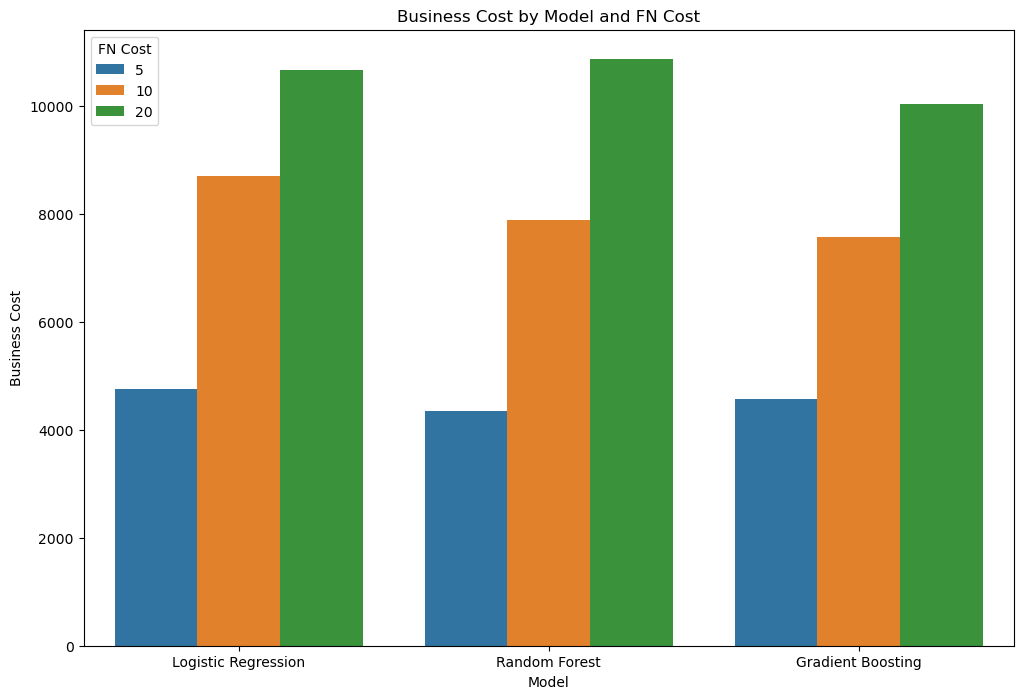

In [27]:
# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(data=comparison_df, x='Model', y='Business Cost', hue='FN Cost')
plt.title('Business Cost by Model and FN Cost')
plt.ylabel('Business Cost')
plt.xlabel('Model')
plt.legend(title='FN Cost')
plt.show()

Best Threshold by Model and FN Cost : Ce graphique montre le meilleur seuil pour chaque modèle en fonction du coût des faux négatifs. On observe que les seuils varient significativement en fonction du coût FN et du modèle.

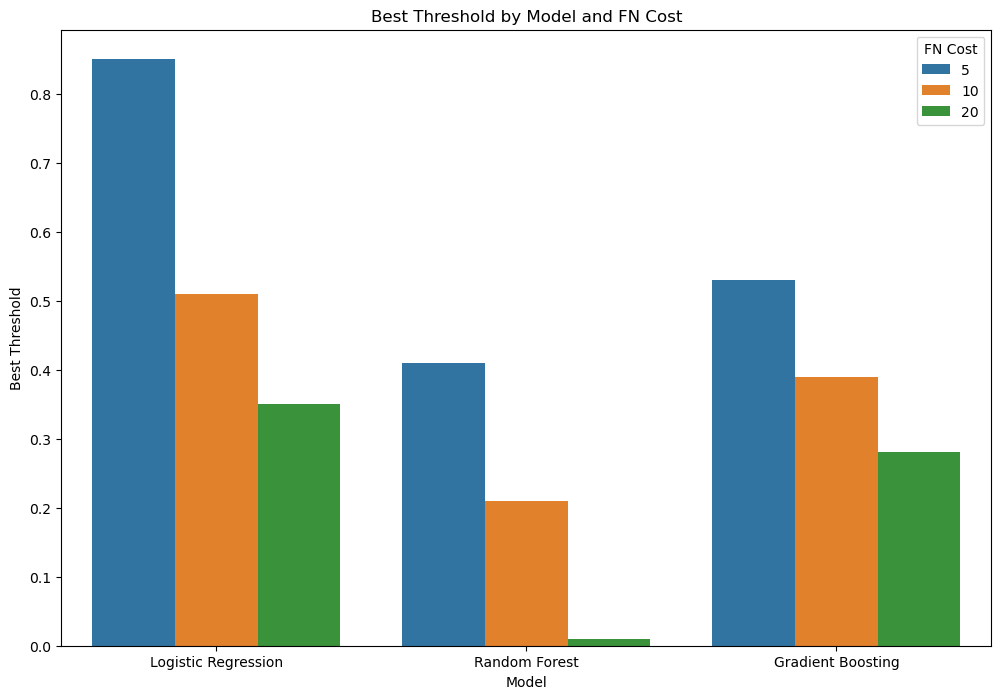

In [28]:
plt.figure(figsize=(12, 8))
sns.barplot(data=comparison_df, x='Model', y='Best Threshold', hue='FN Cost')
plt.title('Best Threshold by Model and FN Cost')
plt.ylabel('Best Threshold')
plt.xlabel('Model')
plt.legend(title='FN Cost')
plt.show()

In [29]:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer

In [30]:

# Créer l'objet explainer SHAP
explainer_lr = shap.Explainer(best_lr, X_train)


In [31]:
# Calculer les valeurs SHAP pour l'ensemble de test
shap_values_lr = explainer_lr(X_test)


In [32]:
# Initialisation de JavaScript pour les visualisations SHAP
shap.initjs()

# Visualisation des valeurs SHAP pour une prédiction individuelle
shap.force_plot(shap_values_lr[0])



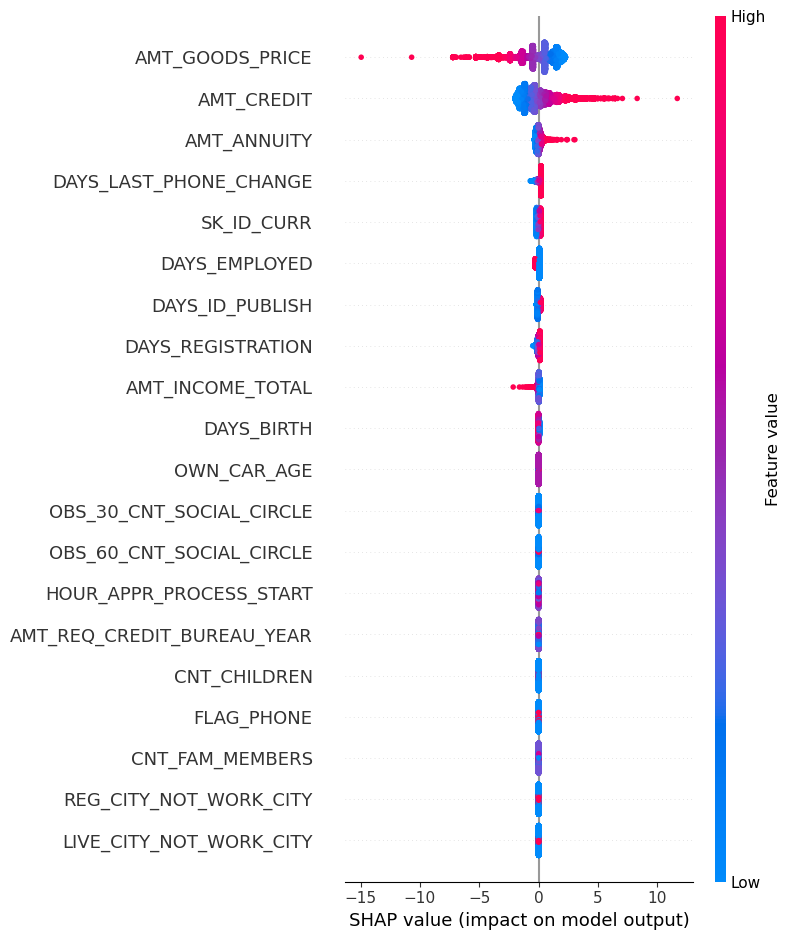

In [33]:
# Visualisation globale des valeurs SHAP
shap.summary_plot(shap_values_lr, X_test)


In [34]:
# Extraire les valeurs SHAP
shap_values_array = shap_values_lr.values if hasattr(shap_values_lr, 'values') else shap_values_lr

# Extraire les indices des 10 caractéristiques les plus importantes
importances = np.abs(shap_values_array).mean(axis=0)
indices = np.argsort(importances)[-10:]  # Obtenir les indices des 10 caractéristiques les plus importantes
important_features = X_test.columns[indices]
print("Les 10 caractéristiques les plus importantes sont :")
print(important_features)

Les 10 caractéristiques les plus importantes sont :
Index(['DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'SK_ID_CURR',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_ANNUITY', 'AMT_CREDIT',
       'AMT_GOODS_PRICE'],
      dtype='object')


In [35]:

# Créer l'objet explainer SHAP
explainer_rf = shap.Explainer(best_rf, X_train)


In [36]:
# Initialiser les SHAP explainers pour chaque modèle avec check_additivity=False
explainers = {
    "Random Forest": shap.TreeExplainer(best_rf, check_additivity=False),
    "Gradient Boosting": shap.TreeExplainer(best_gb, check_additivity=False),
    "Logistic Regression": shap.LinearExplainer(best_lr, X_train, check_additivity=False)
}

In [47]:
import pickle

# Supposez que best_lr est votre modèle de régression logistique déjà entraîné
with open('best_gb.pkl', 'wb') as model_file:
    pickle.dump(best_gb, model_file)